In [48]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 30 13:39:49 2022

@author: 
Taroni Anna
Le Floch Yann
Simon Léonard
Matthieu Nina
Miranda Flavie
"""

# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import numpy as np
import pandas as pd
import dm4bem
import matplotlib.pyplot as plt


# P-controler gain
#Kp = 1e4            # almost perfect controller Kp -> ∞
Kp = 1e-3           # no controller Kp -> 0


L = 12
lw1 = 3
lw2 = 6.2
hi= 2.5
lc = 2.5
ldoor = 1
Sw1=hi*lw1
Sw2=hi*lw2
Swext = (lw2-lw1)*hi
Swint = (lw2 - ldoor)*hi
Sext = Swext + Sw1
Sdoor = ldoor*hi
Sc=lc*hi
#Ssomme = 2*Sgrand + 3*Sptiot + 2*Sc  # m² surface of concrete & insulation of the 5 walls

#volume_air
Va_c = lc*hi*lw2
Va_r = lw2*L*hi
Va = Va_c + Va_r

#materials
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K

wall_ext = {'Conductivity': [0.035, 0.16, 0.035 ],  # W/m.K
        'Density': [800, 350, 800],        # kg/m³
        'Specific heat': [1000, 840, 1000],  # J/kg.K
        'Width': [0.03, 0.3, 0.03],
        'Surface': [Sext, Sext, Sext],  # m²
       }                # number of discretizations
wall_ext = pd.DataFrame(wall_ext, index=['Insulation', 'Concrete', 'Insulation'])


window1 = {'Conductivity': [1.015],  # W/m.K
        'Density': [2500],        # kg/m³
        'Specific heat': [720],  # J/kg.K
        'Width': [0.006],
        'Surface': [Sw1],  # m²
       }                # number of discretizations
window1 = pd.DataFrame(window1, index=[ 'Glass'])

window2 = {'Conductivity': [1.015],  # W/m.K
        'Density': [2500],        # kg/m³
        'Specific heat': [720],  # J/kg.K
        'Width': [0.006],
        'Surface': [Sw2],  # m²
       }                # number of discretizations
window2 = pd.DataFrame(window2, index=[ 'Glass'])

wall_int = {'Conductivity': [0.035, 0.16 ],  # W/m.K
        'Density': [800, 350],        # kg/m³
        'Specific heat': [1000, 840],  # J/kg.K
        'Width': [0.03, 0.3],
        'Surface': [Sext, Sext],  # m²
       }                # number of discretizations
wall_int = pd.DataFrame(wall_int, index=['Insulation', 'Concrete'])

door = {'Conductivity': [0.16],  # W/m.K
        'Density': [450],        # kg/m³
        'Specific heat': [2000],  # J/kg.K
        'Width': [0.05],
        'Surface': [Sdoor],  # m²
       }                # number of discretizations
door = pd.DataFrame(door, index=['Wood'])




ε_wLW = 0.9     # long wave wall emmisivity (concrete)
α_wSW = 0.2     # absortivity white surface
ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
τ_gSW = 0.83    # short wave glass transmitance (glass)
α_gSW = 0.1     # short wave glass absortivity
#
σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant
#
#
Fwg = 1 / 5     # view factor wall - glass
#
#
#
Tm = 20 + 273   # mean temp for radiative exchange

# convection coefficients, W/m² K
h = pd.DataFrame([{'in': 4, 'out': 10}])

h = np.array([4, 10])
# Conduction
G_cd_wall_ext = wall_ext['Conductivity'] / wall_ext['Width'] * wall_ext['Surface']
G_cd_wall_int = wall_int['Conductivity'] / wall_int['Width'] * wall_int['Surface']
G_cd_door = door['Conductivity'] / door['Width'] * door['Surface']
G_cd_window1 = window1['Conductivity'] / window1['Width'] * window1['Surface']
G_cd_window2 = window2['Conductivity'] / window2['Width'] * window2['Surface']

# Convection
G_wall_ext = h * wall_ext['Surface'][0]  # wall
G_wall_int = h * wall_int['Surface'][0]     # wall
G_door = h * door['Surface'][0]  #door
G_window1 = h * window1['Surface'][0] #window1
G_window2 = h * window2['Surface'][0]  #window2

# # Long-wave radiation exchnage
# GLW1 = ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW2 = Fwg * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW3 = ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass'] * 4 * σ * Tm**3
#
#
# # long-wave exg. wall-glass
# GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)
#
# # ventilation & advection
# Gv = Va_dot * air['Density'] * air['Specific heat']

# glass: convection outdoor & conduction
Ggs1 = 1 / (1 / G_window1[0] + 1 / (2 * G_cd_window1))
Ggs2 = 1 / (1 / G_window2[1] + 1 / (2 * G_cd_window2))

#door
G_door_tot = float(1 / (1 / G_door[0] + 1 / (2 * G_cd_door)))

# Thermal capacities
C_wall_ext = wall_ext['Density'] * wall_ext['Specific heat'] * wall_ext['Surface'] * wall_ext['Width']
C_wall_int = wall_int['Density'] * wall_int['Specific heat'] * wall_int['Surface'] * wall_int['Width']
C_window1 = window1['Density'] * window1['Specific heat'] * window1['Surface'] * window1['Width']
C_window2 = window2['Density'] * window2['Specific heat'] * window2['Surface'] * window2['Width']
C_door = door['Density'] * door['Specific heat'] * door['Surface'] * door['Width']
C_air = air['Density'] * air['Specific heat'] * Va


#Incidence matrix
A = np.zeros([19, 16])
A[0, 0] = 1
A[1, 0], A[1, 15] = -1, 1
A[2, 15], A[2, 1] = -1, 1
A[3, 1], A[3, 2] = -1, 1
A[4, 2], A[4, 3] = -1, 1
A[5, 3], A[5, 4] = -1, 1
A[6, 4], A[6, 5] = -1, 1
A[7, 5], A[7, 14] = -1, 1
A[10, 14],  A[10, 15] = 1,-1
A[8, 14], A[8, 6] = 1, -1
A[9, 6]= 1
A[18, 13]= 1
A[17, 13], A[18, 12] = -1,1
A[16, 12], A[18, 11] = 1,-1
A[14, 10], A[18, 9] = -1,1
A[13, 9], A[18, 8] = -1,1
A[12, 8], A[18, 7] = -1,1
A[11, 7], A[11, 14] = 1,-1
np.set_printoptions(suppress=False)


g = np.zeros(19)
g[0] = Ggs2
g[1] = G_window2[0]
g[2] = G_wall_int[0]
g[3] = 2*G_cd_wall_int[1]
g[4] = 2*G_cd_wall_int[1]
g[5] = 2*G_cd_wall_int[0]
g[6] = 2*G_cd_wall_int[0]
g[7] = G_wall_int[0]
g[8] = Ggs1
g[9] = G_window1[1]
g[10]= G_door_tot
g[11]=G_wall_ext[0]
g[12]=2*G_cd_wall_ext[0]
g[13]=2*G_cd_wall_ext[0]
g[14]=2*G_cd_wall_ext[1]
g[15]=2*G_cd_wall_ext[1]
g[16]=2*G_cd_wall_ext[2]
g[17]=2*G_cd_wall_ext[2]
g[18]=G_wall_ext[1]

G = np.diag(g)
np.set_printoptions(precision=3, threshold=16, suppress=True)

#Thermal capacities
c = np.zeros(16)
c[2] = C_wall_int[1]
c[4] = C_wall_int[0]
c[8] = C_wall_ext[0]
c[10] =C_wall_ext[1]
c[12] =C_wall_ext[2]

C = np.diag(c)

#constraints
"""
b = np.zeros(19)
b[[0, 9, 18]] = np.array([10, 10, 10]) + 273 #températures imposées

f = np.zeros(16)
f[[0, 1, 5, 6, 7, 13, 14]] = 1000 + np.array([0, 4000, 6000, 7000, 300, 12, 4040]) #source (soleil)

y = np.ones(16)

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

# Thermal circuit -> state-space
# ==============================
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

# Test: comparison steady-state of thermal circuit and state-space
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

"""
b = np.zeros(19)
b[[0, 9, 18]] = np.array([10, 10, 10]) + 273

f = np.zeros(16)
f[[0, 1, 5, 6, 7, 13, 14]] = 1000 + np.array([800, 400, 500, 7000, 300, 12, 4040])

y = np.zeros(16)
y[14] = 1
y[15] = 1

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])


[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
yade = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(yade, precision=3, suppress_small=True))

df = pd.DataFrame(data=[yss, yade])

[632.33  387.945]
[322.081 429.553 500.906 572.259 604.878 637.496 458.419 653.298   0.
   0.      0.    398.28    0.     27.982 632.33  387.945]


In [49]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 30 13:39:49 2022

@author: taronian
"""

# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import numpy as np
import pandas as pd
import dm4bem
import matplotlib.pyplot as plt



# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0

L = 12
lw1 = 3
lw2 = 6.2
hi= 2.5
lc = 2.5
ldoor = 1
Sw1=hi*lw1
Sw2=hi*lw2
Swext = (lw2-lw1)*hi
Swint = (lw2 - ldoor)*hi
Sext = Swext + Sw1
Sdoor = ldoor*hi
Sc=lc*hi
#Ssomme = 2*Sgrand + 3*Sptiot + 2*Sc  # m² surface of concrete & insulation of the 5 walls

#volume_air
Va_c = lc*hi*lw2
Va_r = lw2*L*hi
Va = Va_c + Va_r

#materials
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K

wall_ext = {'Conductivity': [0.035, 0.16, 0.035 ],  # W/m.K
        'Density': [800, 350, 800],        # kg/m³
        'Specific heat': [1000, 840, 1000],  # J/kg.K
        'Width': [0.03, 0.3, 0.03],
        'Surface': [Sext, Sext, Sext],  # m²
       }                # number of discretizations
wall_ext = pd.DataFrame(wall_ext, index=['Insulation', 'Concrete', 'Insulation'])


window1 = {'Conductivity': [1.015],  # W/m.K
        'Density': [2500],        # kg/m³
        'Specific heat': [720],  # J/kg.K
        'Width': [0.006],
        'Surface': [Sw1],  # m²
       }                # number of discretizations
window1 = pd.DataFrame(window1, index=[ 'Glass'])

window2 = {'Conductivity': [1.015],  # W/m.K
        'Density': [2500],        # kg/m³
        'Specific heat': [720],  # J/kg.K
        'Width': [0.006],
        'Surface': [Sw2],  # m²
       }                # number of discretizations
window2 = pd.DataFrame(window2, index=[ 'Glass'])

wall_int = {'Conductivity': [0.035, 0.16 ],  # W/m.K
        'Density': [800, 350],        # kg/m³
        'Specific heat': [1000, 840],  # J/kg.K
        'Width': [0.03, 0.3],
        'Surface': [Sext, Sext],  # m²
       }                # number of discretizations
wall_int = pd.DataFrame(wall_int, index=['Insulation', 'Concrete'])

door = {'Conductivity': [0.16],  # W/m.K
        'Density': [450],        # kg/m³
        'Specific heat': [2000],  # J/kg.K
        'Width': [0.05],
        'Surface': [Sdoor],  # m²
       }                # number of discretizations
door = pd.DataFrame(door, index=['Wood'])




# ε_wLW = 0.9     # long wave wall emmisivity (concrete)
# α_wSW = 0.2     # absortivity white surface
# ε_gLW = 0.9     # long wave glass emmisivity (glass pyrex)
# τ_gSW = 0.83    # short wave glass transmitance (glass)
# α_gSW = 0.1     # short wave glass absortivity
#
# σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant
#
#
# Fwg = 1 / 5     # view factor wall - glass
#
#
#
# Tm = 20 + 273   # mean temp for radiative exchange

# convection coefficients, W/m² K
#h = pd.DataFrame([{'in': 4, 'out': 10}])

h = np.array([4, 10])
# Conduction
G_cd_wall_ext = wall_ext['Conductivity'] / wall_ext['Width'] * wall_ext['Surface']
G_cd_wall_int = wall_int['Conductivity'] / wall_int['Width'] * wall_int['Surface']
G_cd_door = door['Conductivity'] / door['Width'] * door['Surface']
G_cd_window1 = window1['Conductivity'] / window1['Width'] * window1['Surface']
G_cd_window2 = window2['Conductivity'] / window2['Width'] * window2['Surface']

# Convection
G_wall_ext = h * wall_ext['Surface'][0]  # wall
G_wall_int = h * wall_int['Surface'][0]     # wall
G_door = h * door['Surface'][0]  #door
G_window1 = h * window1['Surface'][0] #window1
G_window2 = h * window2['Surface'][0]  #window2

# # Long-wave radiation exchnage
# GLW1 = ε_wLW / (1 - ε_wLW) * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW2 = Fwg * wall['Surface']['Insulation'] * 4 * σ * Tm**3
# GLW3 = ε_gLW / (1 - ε_gLW) * wall['Surface']['Glass'] * 4 * σ * Tm**3
#
#
# # long-wave exg. wall-glass
# GLW = 1 / (1 / GLW1 + 1 / GLW2 + 1 / GLW3)
#
# # ventilation & advection
# Gv = Va_dot * air['Density'] * air['Specific heat']

# glass: convection outdoor & conduction
Ggs1 = 1 / (1 / G_window1[0] + 1 / (2 * G_cd_window1))
Ggs2 = 1 / (1 / G_window2[1] + 1 / (2 * G_cd_window2))

#door
G_door_tot = float(1 / (1 / G_door[0] + 1 / (2 * G_cd_door)))

# Thermal capacities
C_wall_ext = wall_ext['Density'] * wall_ext['Specific heat'] * wall_ext['Surface'] * wall_ext['Width']
C_wall_int = wall_int['Density'] * wall_int['Specific heat'] * wall_int['Surface'] * wall_int['Width']
C_window1 = window1['Density'] * window1['Specific heat'] * window1['Surface'] * window1['Width']
C_window2 = window2['Density'] * window2['Specific heat'] * window2['Surface'] * window2['Width']
C_door = door['Density'] * door['Specific heat'] * door['Surface'] * door['Width']
C_air = air['Density'] * air['Specific heat'] * Va


#Incidence matrix
A = np.zeros([19, 16])
A[0, 0] = 1
A[1, 0], A[1, 15] = -1, 1
A[2, 15], A[2, 1] = -1, 1
A[3, 1], A[3, 2] = -1, 1
A[4, 2], A[4, 3] = -1, 1
A[5, 3], A[5, 4] = -1, 1
A[6, 4], A[6, 5] = -1, 1
A[7, 5], A[7, 14] = -1, 1
A[10, 14],  A[10, 15] = 1,-1
A[8, 14], A[8, 6] = 1, -1
A[9, 6]= 1
A[18, 13]= 1
A[17, 13], A[18, 12] = -1,1
A[16, 12], A[18, 11] = 1,-1
A[14, 10], A[18, 9] = -1,1
A[13, 9], A[18, 8] = -1,1
A[12, 8], A[18, 7] = -1,1
A[11, 7], A[11, 14] = 1,-1
np.set_printoptions(suppress=False)


g = np.zeros(19)
g[0] = Ggs2
g[1] = G_window2[0]
g[2] = G_wall_int[0]
g[3] = 2*G_cd_wall_int[1]
g[4] = 2*G_cd_wall_int[1]
g[5] = 2*G_cd_wall_int[0]
g[6] = 2*G_cd_wall_int[0]
g[7] = G_wall_int[0]
g[8] = Ggs1
g[9] = G_window1[1]
g[10]= G_door_tot
g[11]=G_wall_ext[0]
g[12]=2*G_cd_wall_ext[0]
g[13]=2*G_cd_wall_ext[0]
g[14]=2*G_cd_wall_ext[1]
g[15]=2*G_cd_wall_ext[1]
g[16]=2*G_cd_wall_ext[2]
g[17]=2*G_cd_wall_ext[2]
g[18]=G_wall_ext[1]

G = np.diag(g)
np.set_printoptions(precision=3, threshold=16, suppress=True)

#Thermal capacities
c = np.zeros(16)
c[2] = C_wall_int[1]
c[4] = C_wall_int[0]
c[8] = C_wall_ext[0]
c[10] =C_wall_ext[1]
c[12] =C_wall_ext[2]

C = np.diag(c)

print(A,G,C)

[[ 1.  0.  0. ...  0.  0.  0.]
 [-1.  0.  0. ...  0.  0.  1.]
 [ 0.  1.  0. ...  0.  0. -1.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  1.  0.  0.]] [[150.55    0.      0.    ...   0.      0.      0.   ]
 [  0.     62.      0.    ...   0.      0.      0.   ]
 [  0.      0.     62.    ...   0.      0.      0.   ]
 ...
 [  0.      0.      0.    ...  36.167   0.      0.   ]
 [  0.      0.      0.    ...   0.     36.167   0.   ]
 [  0.      0.      0.    ...   0.      0.    155.   ]] [[      0.       0.       0. ...       0.       0.       0.]
 [      0.       0.       0. ...       0.       0.       0.]
 [      0.       0. 1367100. ...       0.       0.       0.]
 ...
 [      0.       0.       0. ...       0.       0.       0.]
 [      0.       0.       0. ...       0.       0.       0.]
 [      0.       0.       0. ...       0.       0.       0.]]


In [50]:
#First part :  Static constraints

b = np.zeros(19)
b[[0, 9, 18]] = np.array([10, 10, 10]) + 273

f = np.zeros(16)
f[[0, 1, 5, 6, 7, 13, 14]] = 1000 + np.array([800, 400, 500, 7000, 300, 12, 4040])

y = np.zeros(16)
y[14] = 1
y[15] = 1

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])


[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
yade = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(yade, precision=3, suppress_small=True))

df = pd.DataFrame(data=[yss, yade])

[632.33  387.945]
[322.081 429.553 500.906 572.259 604.878 637.496 458.419 653.298   0.
   0.      0.    398.28    0.     27.982 632.33  387.945]


Maximum time step: 20571.43 s


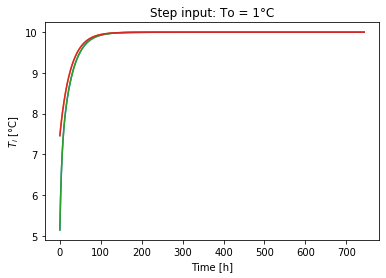

Steady-state indoor temperature obtained with:
- DAE model: 1.0430 °C


TypeError: only size-1 arrays can be converted to Python scalars

In [54]:
b = np.zeros(19)
b[[0, 9, 18]] = 1

f = np.zeros(16)
f[[0, 1, 5, 6, 7, 13, 14]] = 1

y = np.zeros(16)
y[14] = 1
y[15] = 1

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

# Thermal circuit -> state-space
# ==============================
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

dt = 360

duration = 3600 * 24 * 31

n = int(np.floor(duration / dt))

t = np.arange(0, n * dt, dt) 

# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To Tsp Phio Phii Qaux Phia]
u = np.zeros([10, n])
u[0:3, :] = 10 * np.ones([3, n])

temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])
        
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')
plt.show()


ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[6]:.4f} °C')
print(f'- response to step input:{float(y_exp[:, -2]):.4f} °C')

[1.118 1.047]
[1.018 1.069 1.089 1.11  1.119 1.129 1.043 1.134 0.    0.    0.    0.162
 0.    0.028 1.118 1.047]


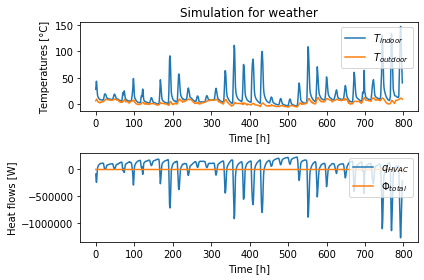

In [52]:

b = np.zeros(19)
b[[0, 9, 18]] = 1

f = np.zeros(16)
f[[0, 1, 5, 6, 7, 13, 14]] = 1

y = np.zeros(16)
y[14] = 1
y[15] = 1

u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])


[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
yade = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(yade, precision=3, suppress_small=True))

df = pd.DataFrame(data=[yss, yade])


#Simulation with weather data

dt = 360
duration = 3600 * 24 * 2

filename = 'FRA_Lyon.074810_IWEC.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

#SOLAR IRRADIATION

surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

#TIME STEP OF dt
data = pd.concat([weather['temp_air'], rad_surf1['Φt1']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})

#Indoor temperature setpoint
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])

#Time
t = dt * np.arange(data.shape[0])

#Input vector is formed by the temperature sources and the heat flow sources 
# Vectors of state and input (in time)
n_tC = As.shape[0]
u = pd.concat([data['To'], data['To'], data['To'], data['Ti'],
               α_wSW * Swext * data['Φt1'],α_wSW * Swext * data['Φt1'],α_wSW * Swext * data['Φt1'],
               τ_gSW * α_wSW * (Sw1+Sw2) * data['Φt1'],
               data['Qa'],
               α_gSW * (Sw1+Sw2) * data['Φt1']], axis=1)
#Initial value of state vector
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#Euler integration in time
I = np.eye(n_tC)
for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]




###PLOT

y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()
